In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from lumina.genetic.signal.method import *
from lumina.genetic.strategy.method import *
from kdutils.macro2 import *

In [3]:
from lib.cux002 import StrategyEvaluate1

In [4]:
def read_factors(method, instruments, task_id, period, name):
    dirs = os.path.join(base_path, method, instruments, 'temp', "model",
                        str(task_id), str(period))
    filename = os.path.join(dirs, "{0}_predict_data.feather".format(name))
    predict_data = pd.read_feather(filename)
    is_on_mark = predict_data['trade_time'].dt.minute % int(period) == 0
    predict_data = predict_data[is_on_mark]
    predict_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    predict_data.dropna(inplace=True)
    return predict_data

In [5]:
def signal_function(factors_data, signal_method, signal_params):
    pos_data = eval(signal_method)(factor_data=factors_data, **signal_params)
    return pos_data


def strategy_function(pos_data, total_data, strategy_method, strategy_params):
    pos_data1 = eval(strategy_method)(signal=pos_data,
                                      total_data=total_data,
                                      **strategy_params)
    return pos_data1

In [6]:
method = 'cicso0'
instruments = 'ims'
task_id = '200037'
period = 5
name = 'linear'
signal_method = 'adaptive_signal'
signal_params = {'roll_num': 25, 'threshold': 0.9}
strategy_settings = {'commission': 0.000023, 'slippage': 0, 'size': 200}

In [7]:
predict_data = read_factors(method=method,
                                instruments=instruments,
                                task_id=task_id,
                                period=period,
                                name=name)
predict_data.head()

,trade_time,code,predict,nxt1_ret_5h
0,2024-12-05 10:20:00,IM,-5.284011,-0.001860
5,2024-12-05 10:25:00,IM,-0.186690,-0.000206
10,2024-12-05 10:30:00,IM,-1.949980,0.003050
15,2024-12-05 10:35:00,IM,-0.980163,0.004669
20,2024-12-05 10:40:00,IM,-5.241567,0.000327


In [8]:
total_data2 = predict_data.set_index(['trade_time', 'code']).unstack()
total_data2.head()

,predict,nxt1_ret_5h
code,IM,IM
trade_time,,
2024-12-05 10:20:00,-5.284011,-0.001860
2024-12-05 10:25:00,-0.186690,-0.000206
2024-12-05 10:30:00,-1.949980,0.003050
2024-12-05 10:35:00,-0.980163,0.004669
2024-12-05 10:40:00,-5.241567,0.000327


In [9]:
factors_data = predict_data.set_index(
        ['trade_time',
         'code'])[['predict']].rename(columns={'predict': 'transformed'})
factors_data.head()

,,transformed
trade_time,code,
2024-12-05 10:20:00,IM,-5.284011
2024-12-05 10:25:00,IM,-0.186690
2024-12-05 10:30:00,IM,-1.949980
2024-12-05 10:35:00,IM,-0.980163
2024-12-05 10:40:00,IM,-5.241567


In [10]:
pos_data = eval(signal_method)(factor_data=factors_data, **signal_params)

In [11]:
#turnover_series_min = pos_data.stack().dropna().diff().abs().fillna(0)
#turnover_series_min#.resample('D').sum() 

In [12]:
#turnover_series_min.droplevel('code').resample('D').mean().fillna(0).plot(color='teal', use_index=True)

In [13]:
eval1 = StrategyEvaluate1(pos_data=pos_data, total_data=total_data2,
                  strategy_settings=strategy_settings,
                  strategy_name='adaptive_signal',
                  ret_name='nxt1_ret_5h',
)

In [14]:
eval1.run()#['turnover'].mean()

{'final_return': 0.050274952568963416,
 'annual_return': 0.13514706886835048,
 'sharpe_ratio': 1.6411301552723667,
 'calmar_ratio': 6.839650086039874,
 'p/l_ratio': 1.099218921428703,
 'win_ratio': 0.11310116086235489,
 'turnover': 0.23383084577114427,
 'max_drawdown': -0.03404227257866855,
 'downside_risk': 0.04996462900734022,
 'annual_volatility': 0.07914724971739384}

In [15]:
#eval1.pos_data.stack().droplevel(level=1)

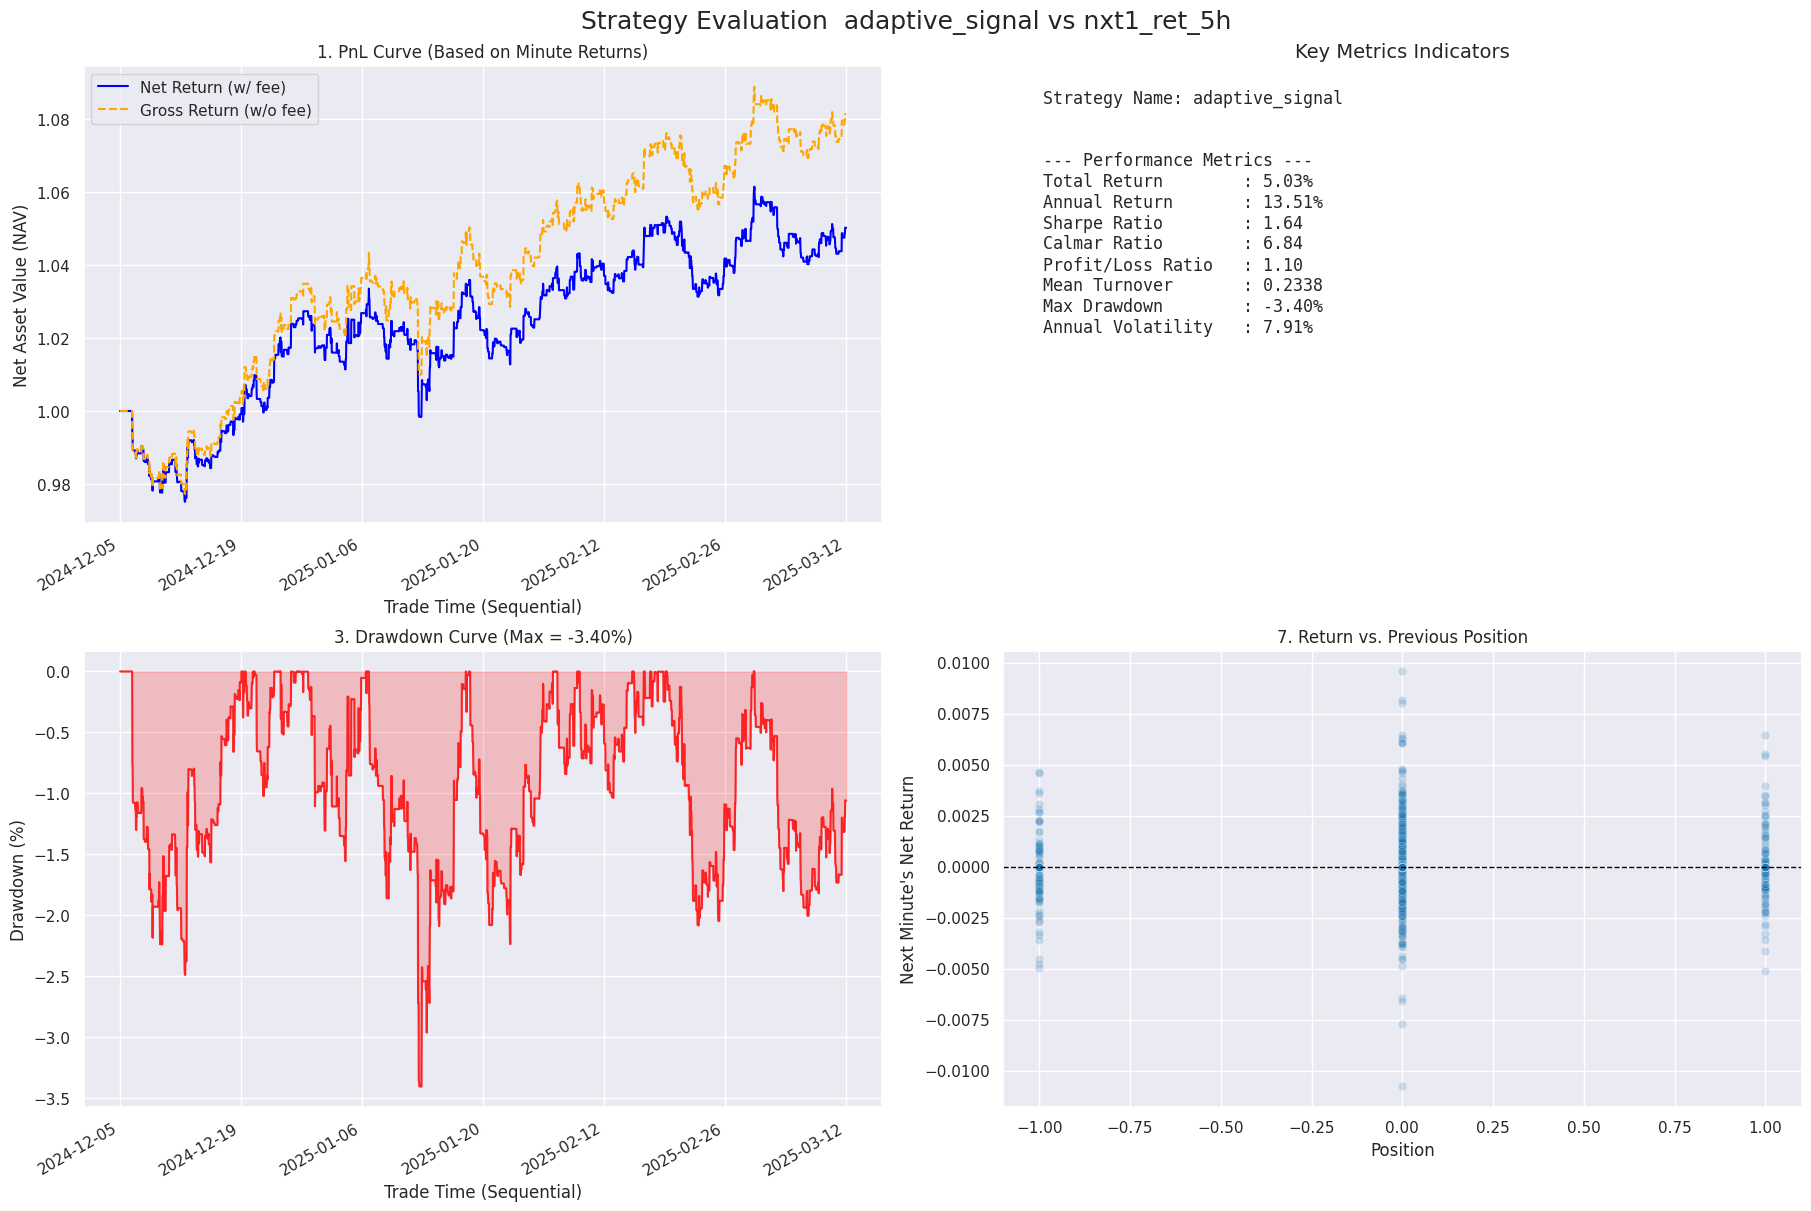

In [16]:
eval1.plot_results()

In [23]:
eval1.min_returns['a_ret']

trade_time
2024-12-05 10:20:00   -0.000000
2024-12-05 10:25:00   -0.000000
2024-12-05 10:30:00    0.000000
2024-12-05 10:35:00    0.000000
2024-12-05 10:40:00    0.000000
                         ...   
2025-03-12 14:40:00    0.001373
2025-03-12 14:45:00   -0.000023
2025-03-12 14:50:00    0.000000
2025-03-12 14:55:00   -0.000000
2025-03-12 15:00:00   -0.000000
Name: a_ret, Length: 3015, dtype: float64

,pos,a_ret
trade_time,,
2024-12-05 10:20:00,0,-0.000000
2024-12-05 10:25:00,0,-0.000000
2024-12-05 10:30:00,0,0.000000
2024-12-05 10:35:00,0,0.000000
2024-12-05 10:40:00,0,0.000000
...,...,...
2025-03-12 14:40:00,0,0.001373
2025-03-12 14:45:00,0,-0.000023
2025-03-12 14:50:00,0,0.000000
